In [15]:
import numpy as np
from market import market
import pandas as pd
from randomAgent import Agent
import itertools
from IPython.display import display
import matplotlib.pyplot as plt

In [16]:
class linearRegression:
    
    def __init__(self, dim):
        self.W = np.random.randn(dim[0],dim[1])
        self.b = np.zeros(dim[1])
        self.historical_cost = []
        
    def train(self, X, Y, learning_rate=0.001):

        # Normalize 
        X_norm = (X - X.mean()) / X.std()
        Y_norm = (Y - Y.mean()) / Y.std()

        # Make predictions and calculate gradients
        pred = self.predict(X_norm)
        n_val = np.prod(Y_norm.shape)
        gW = 2 * X_norm.T.dot(pred - Y_norm) / n_val
        gb = 2 * (pred - Y_norm).sum(axis=0) / n_val

        # Update weights and biases
        self.W -= learning_rate * gW
        self.b -= learning_rate * gb

        # Calculate prediction error and add to historical cost
        self.prediction_error = np.mean((pred - Y_norm)**2)
        self.historical_cost.append(self.prediction_error)

         
    def predict(self,X):
        return X.dot(self.W) + self.b



In [17]:
class SmartAgent:
    
    def __init__(self, dim):
        self.model = linearRegression((dim))
    
    def get_action(self, x):
        pred = self.model.predict(x)
        action = np.argmax(pred)
        return action


In [18]:
env = market(['AAPL','MSFT'])
env.total_days
dados_treino = int((env.total_days*0.7))
dados_treino

6352

In [19]:
train_env =  market(['AAPL','MSFT'] , start_row=0, end_row=dados_treino)
test_env =  market(['AAPL','MSFT'] , start_row=dados_treino+1)
train_env.total_days
test_env.total_days

2722

In [20]:
dim = np.array([env.state_size,len(env.action_list)])
smartagent = SmartAgent(dim)
randomagent = Agent(len(test_env.index_actions))

In [21]:
def train(agent, market , itr):

    for i in range(itr):

        state = market.start()
        done = False
        x = np.array([market._get_state()])
        v_capital = market.get_episode_value()

        while not done:
            valores_estimados = agent.model.predict(x)
            action = agent.get_action(x)
            #r = v_capital - valores_estimados[0][action]
            valores_estimados[0][action] = v_capital
            agent.model.train(x, valores_estimados)
            #print(f"Day: {market.today} // state: {market._get_state()} // Ação {action} // {market.get_episode_value()}")
            print(f"Day: {market.today} // Ação {action} // {smartagent.model.prediction_error}")
            smartagent.model.historical_cost
            next_state, reward, done = market.new_day(action)
            state = next_state
            v_capital = market.get_episode_value()
            x = np.array([market._get_state()])

    return market.get_episode_value()

In [22]:
train(smartagent,train_env,1)

Day: 0 // Ação 0 // 5.918317217020389
Day: 1 // Ação 0 // 5.904310279068151
Day: 2 // Ação 0 // 5.890336799367137
Day: 3 // Ação 0 // 5.8764022012718025
Day: 4 // Ação 0 // 5.86250190043128
Day: 5 // Ação 0 // 5.848643540444062
Day: 6 // Ação 0 // 5.834816446738035
Day: 7 // Ação 0 // 5.821025585490819
Day: 8 // Ação 0 // 5.807276939154403
Day: 9 // Ação 0 // 5.793563271767227
Day: 10 // Ação 0 // 5.7798850801031545
Day: 11 // Ação 0 // 5.766242857199491
Day: 12 // Ação 0 // 5.75263457862192
Day: 13 // Ação 0 // 5.739065178469998
Day: 14 // Ação 0 // 5.725531296523772
Day: 15 // Ação 0 // 5.712033276085547
Day: 16 // Ação 0 // 5.698572638086925
Day: 17 // Ação 0 // 5.6851479545290164
Day: 18 // Ação 0 // 5.6717570625619835
Day: 19 // Ação 0 // 5.658403104442711
Day: 20 // Ação 0 // 5.645083919800478
Day: 21 // Ação 0 // 5.631800290925252
Day: 22 // Ação 0 // 5.618553292258409
Day: 23 // Ação 0 // 5.605342976173498
Day: 24 // Ação 0 // 5.592167028230074
Day: 25 // Ação 0 // 5.5790253474

422652.74660015106

In [23]:
def play_episode(agent,market):

    state = market.start()
    done = False
    x = np.array([market._get_state()])
  
    while not done:
    
        action = agent.get_action(x)
        #print(f"Day: {market.today} // state: {market._get_state()} // Ação {action} // {market.get_episode_value()}")
        next_state, reward, done = market.new_day(action)
        state = next_state
        x = np.array([market._get_state()])

    return market.get_episode_value()

In [24]:
capital_acoes_smart = play_episode(smartagent,test_env)
capital_acoes_smart

118830.3442401886

In [25]:
def play_random_episode(agent,market):
    state = market.start()
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done = market.new_day(action)
        state = next_state
        market.get_episode_value()

    return market.get_episode_value()

In [32]:
resultado=0
loops = 300
for i in range(loops):
    capital_acoes_aleatorias = play_random_episode(randomagent,test_env)
    resultado += capital_acoes_aleatorias
    if capital_acoes_aleatorias>resultado:
        resultado=capital_acoes_aleatorias
  
media_resultado = resultado/loops  

In [33]:
#print(f'Tivemos um resultado {round((capital_acoes_smart-media_resultado)/media_resultado*100,)} % melhor')
print(f'Tivemos um resultado {round((capital_acoes_smart/media_resultado),2)}x melhor (+{round((capital_acoes_smart-media_resultado)/media_resultado*100,)} %)')

Tivemos um resultado 2.09x melhor (+109 %)


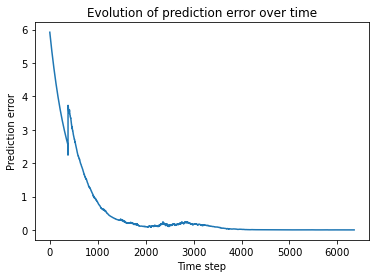

In [28]:
time_steps = range(len(smartagent.model.historical_cost))
plt.plot(time_steps, smartagent.model.historical_cost)
plt.xlabel('Time step')
plt.ylabel('Prediction error')
plt.title('Evolution of prediction error over time')
plt.show()